# Using SedimentPulserEachParcel to add sediment parcels to a channel network
<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to use SedimentPulserEachParcel with a network model grid and the NetworkSedimentTransporter. 

* SedimentPulserEachParcel overview: The user specifies the link and distance on link that parcels are placed within a channel network in a Pandas DataFrame.

In this example we will: 
(1) Set up a network model grid with an initial set of parcels, (2) Add pulses of sediment to the grid using SedimentPulserEachParcel and (3) run NetworkSedimentTransporter between pulses

### 1. Setup the work space

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from landlab.grid.network import NetworkModelGrid
from landlab.plot import plot_network_and_parcels
from landlab.components.network_sediment_transporter.sediment_pulser_each_parcel import SedimentPulserEachParcel
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.components.network_sediment_transporter.bed_parcel_initializers import BedParcelInitializerArea
from landlab.plot import graph

### 2. Define the network model grid topology

In [2]:
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
nodes_at_link = ((1, 0), (1, 2), (7, 1), (3, 1), (4, 3), (5, 4), (6, 4))
nmg = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

#### to help visualize where the pulses will be sent, plot the network with link and node id numbers 

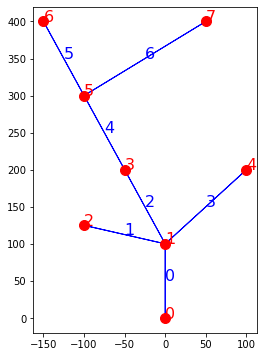

In [3]:
fig, axs = plt.subplots(1,1,figsize=(4,6))
graph.plot_links(nmg, with_id=True)
graph.plot_nodes(nmg, with_id=True)

### 3. Define required link and node fields and run a flow director on the grid to add a slope field

In [4]:
nmg.at_link["channel_width"] = np.array([3, 1.5, 2.5, 2, 2.5, 1.5, 2])  # m
nmg.at_link["channel_slope"] = np.array([0.05, 0.1, 0.06, 0.08, 0.07, 0.1, 0.08])  # m / m
nmg.at_link["reach_length"] = np.array([ 100.0,  103.1, 111.8, 141.4, 111.8, 111.8,  180.3]) # m
nmg.at_node["topographic__elevation"] = np.array([0.0, 5, 10, 10, 10, 15, 20, 20])
nmg.at_node["bedrock__elevation"] = np.array([0.0, 5, 10, 10, 10, 15, 20, 20])
nmg.at_link["drainage_area"] = np.array([1, 0.1, 0.625, 0.15, 0.4, 0.075, 0.2])  # km^2
nmg.at_link["flow_depth"] = np.array([0.7,0.4,0.6,0.4,0.5,0.4,0.4])  # m

# instantiate and run flow director
flow_director= FlowDirectorSteepest(nmg, "topographic__elevation")
flow_director.run_one_step()

### 4. Create an initial set of parcels on the grid. 
#### Note, we start with a small number of initial parcels so that parcels from later pulses of material are visible in plots of the parcels and network

In [5]:
initialize_parcels = BedParcelInitializerArea(nmg, 
                                              drainage_area_coefficient=.1, 
                                              drainage_area_exponent=0.2,
                                              median_number_of_starting_parcels = 2)
parcels = initialize_parcels()

c:\users\keckj\documents\github\landlab\landlab\components\network_sediment_transporter\bed_parcel_initializers.py:515: UserWarning: BedParcelInitializer: At least one link has only [3 1 3 2 2 1 3] parcels.
  warnings.warn(msg)


#### View the initial parcels on the network model grid, shaded by grain diameter

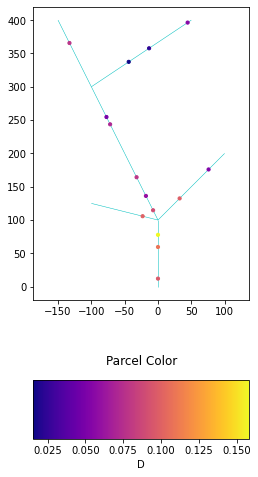

In [6]:
fig = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=0,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6))

#### Viewing the element id of the parcels in the network shows that ParcelInitializer added 15 parcels to the network

In [7]:
parcels.dataset['element_id']

<xarray.DataArray 'element_id' (item_id: 15, time: 1)>
array([[0],
       [0],
       [0],
       [1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [4],
       [4],
       [5],
       [6],
       [6],
       [6]])
Coordinates:
  * time     (time) float64 0.0
  * item_id  (item_id) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Attributes:
    dtype:    <class 'int'>

### 5. Instantiate and run the NetworkSedimentTransporter component using a flow event with flow depth equal to the link field "flow_depth" that last 24 hours 

In [8]:
nst = NetworkSedimentTransporter(
    nmg,
    parcels,
    flow_director,
    bed_porosity = 0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
    active_layer_method="Constant10cm",
)

In [9]:
nst.run_one_step(dt=3600*24)

#### View parcel locations after the flow event

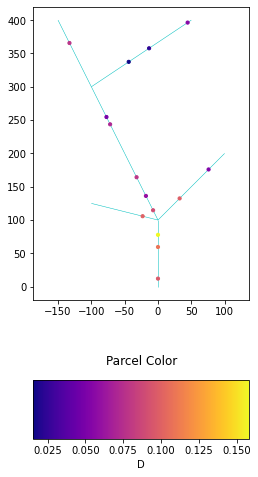

In [10]:
fig = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=1,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6))

#### Note that none of parcels moved because the partial initializer places all parcels in the inactive layer

### 6. Instantiate SedimentPulserEachParcel
SedimentPulserEachParcel is instantiated with a network model grid. Optionally, default parcel attributes and a parcel DataRecord can be defined. If a parcel DataRecord is not provided, SedimentPulserEachParcel will create a new parcel 
DataRecord.

In [11]:
make_pulse = SedimentPulserEachParcel(nmg, parcels = parcels, parcel_volume = 1) # set the default max parcel_volume as 1 m^3

### 7. create the PulseDF (Pulse DataFrame). 
Each row of the PulseDF contains information on the deposition location and 
volume of a single pulse of sediment. The pulse is divided into 'n' number of 
parcels, where 'n' equals numpy.ceil(pulse volume / max parcel volume)
For details on the format of the PulseDF, see the docstring for
function SedimentPulserEachParcel._sediment_pulse_dataframe 

Here we send a pulse to specific locations on links 1, 3, 5 and 2(see first figure for link id's)>
Note that any parcel attributes not specified use default values. Default values can be set when SedimentPulserAtLinks is instantiated.

In [12]:
time = nst.time
                        # volume of each pulse
PulseDF = pd.DataFrame({'pulse_volume': [50, 5, 10, 15], 
                        # pulses enter channel network at these links
                        'link_#': [1, 3, 5, 2], 
                        # the normalized distance on the link (distance from link inlet / link length)
                        'normalized_downstream_distance': [0.8,0.7,0.5,0.2]})   

In [13]:

parcels = make_pulse(time, PulseDF)

Added parcels to DataRecord


#### view the location of the new parcels from the pulse. 
Note that all parcels from a pulse are placed at the same point in the network and appear as 4 points on the plot


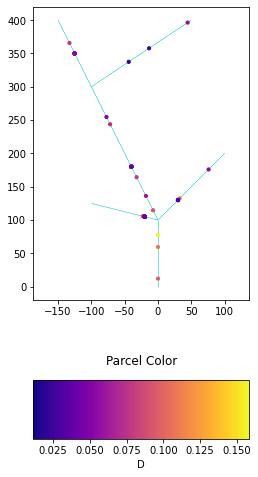

In [14]:
fig = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=1,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6))

#### Viewing the element id of the parcels in the network shows that we actually added roughly 80 new parcels

In [15]:
parcels.dataset['element_id']

<xarray.DataArray 'element_id' (item_id: 95, time: 2)>
array([[  0.,   0.],
       [  0.,   0.],
       [  0.,   0.],
       [  1.,   1.],
       [  2.,   2.],
       [  2.,   2.],
       [  2.,   2.],
       [  3.,   3.],
       [  3.,   3.],
       [  4.,   4.],
       [  4.,   4.],
       [  5.,   5.],
       [  6.,   6.],
       [  6.,   6.],
       [  6.,   6.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
...
       [ nan,   5.],
       [ nan,   5.],
       [ nan,   5.],
       [ nan,   5.],
       [ nan,   5.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.],
       [ nan,   2.]])
Coordinates:
  * time     (time) float64 0.0 8.64e+04
  * item_id  (item_id) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94

#### now apply another 24 hr flow event

In [16]:
nst.run_one_step(dt=3600*24)

#### View parcel locations after the flow event

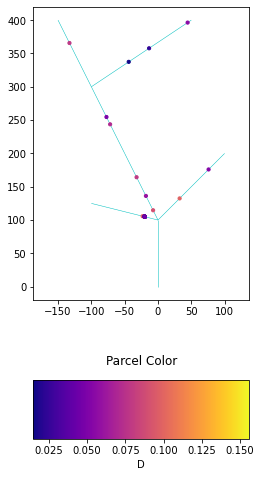

In [17]:
fig = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=2,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6))

Notice that after the flow event, the parcels at each pulse location spread out.

### 8. Send a second pulseDF

This pulseDF includes two pulses:

(1) A 30 m^3 landslide in thin-bedded siltstone near the channel head (inlet) of link 3

(2) A 50 m^3 bedrock landslide in fractured, massive sandstone beds near the outlet of link 6


In [18]:
time = nst.time
PulseDF = pd.DataFrame({'pulse_volume': [30, 50], # pulse volume
                        'link_#': [3, 6], # link id
                        'normalized_downstream_distance': [0.1,0.9], # distance on link
                       'D50': [0.02,.5], # median grain size
                       'D_sd': [0.01, 0.2], # standard deviation of median grain size
                       'abrasion_rate': [ 0.1,0.01], # abrasion rate
                       'parcel_volume':[0.25,2]}) # parcel volume  

In [19]:
parcels = make_pulse(time, PulseDF)

Added parcels to DataRecord


#### view the new parcels

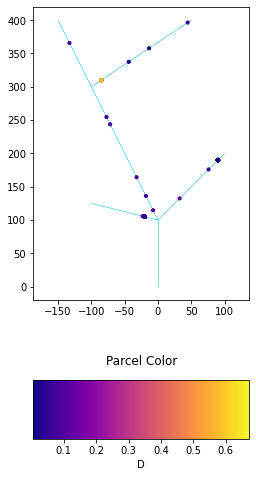

In [20]:
fig  = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=2,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6),
        )

#### apply another day long flow event

In [21]:
nst.run_one_step(dt=3600*24)

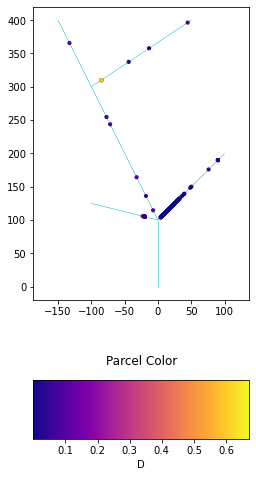

In [22]:
fig  = plot_network_and_parcels(
        nmg, parcels, 
        parcel_time_index=3,  #index of time, not the time value
        parcel_color_attribute="D",
        parcel_size=10, 
        parcel_alpha=1.0,
        figsize=(3,6),
        )

#### Notice how parcels containing the boulder size grains in link 6 did not move but the parcels containing gravel sized grains in link 3 do.